<a href="https://colab.research.google.com/github/sumanyurosha/tensorflow-specialization/blob/master/Hands-on%20ML/chapter12/Customizing_Models_and_Training_Algorithm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow import keras

# **Custom Loss Functions**

In [2]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(300, activation='relu'),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 300)               235500    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


In [3]:
def huber_fn(y_true, y_pred):
    error = y_true - y_pred
    is_error_small = tf.abs(error) < 1
    squared_loss = tf.square(error) / 2
    linear_loss = tf.abs(error) - 0.5
    return tf.where(is_error_small, squared_loss, linear_loss)

In [4]:
model.compile(loss=huber_fn, optimizer='nadam')

In [5]:
tf.keras.models.save_model(model, 'my_model_with_custom_loss.h5')

In [6]:
model = tf.keras.models.load_model('my_model_with_custom_loss.h5', 
                            custom_objects={'huber_fn': huber_fn})

# What if you want to add a threshold to measure whether the error is small or not? 

In [7]:
def create_hubor(threshold=1):
    def huber_fn(y_true, y_pred):
        error = y_true - y_pred
        is_error_small = tf.abs(error) < 1
        squared_loss = tf.square(error) / 2
        linear_loss = threshold * tf.abs(error) - threshold**2 / 2
        return tf.where(is_error_small, squared_loss, linear_loss)
    return huber_fn


In [8]:
model.compile(loss=create_hubor(2.0), optimizer='nadam')

In [9]:
tf.keras.models.save_model(model, 'my_model_with_custom_loss_2.h5')

In [10]:
model = tf.keras.models.load_model('my_model_with_custom_loss_2.h5', 
                                   custom_objects={'huber_fn': create_hubor(2.0)})

# You have to pass the threshold whenever you load the model, so we can overcome this problem by subclassing keras.losses.Loss class

In [11]:
class HuborLoss(keras.losses.Loss):
    def __init__(self, threshold=1.0, **kwargs):
        self.threshold = threshold
        super().__init__(**kwargs)

    def call(self, y_true, y_pred):
        error = y_true - y_pred
        is_error_small = tf.abs(error) < 1
        squared_loss = tf.square(error) / 2
        linear_loss = threshold * tf.abs(error) - threshold**2 / 2
        return tf.where(is_error_small, squared_loss, linear_loss)
    
    def get_config(self):
        base_config = super().get_config()
        return {**base_config, 'threshold': self.threshold}

In [12]:
model.compile(loss=HuborLoss(2.), optimizer='nadam')

In [13]:
keras.models.save_model(model, 'my_model_with_custom_loss_3.h5')

In [14]:
model = keras.models.load_model('my_model_with_custom_loss_3.h5', 
                                custom_objects={'HuborLoss': HuborLoss})

# **Custom Activation**

In [15]:
def my_softplus(z):
    return tf.log(tf.exp(z) + 1.)

# **Custom Initializer**

In [16]:
def my_glorot_initializer(shape, dtype=tf.float32):
    stddev = tf.sqrt(2. / shape[0] + shape[1])
    return tf.random.normal(shape, stdev=stdev, dtype=dtype)

# Custom Regularizer

In [17]:
def my_l1_regularizer(weights):
    return tf.reduce_sum(tf.abs(0.01 * weights))

# **Custom Constraint**

In [18]:
def my_postivie_weight(weights):
    return tf.where(weights < 0., tf.zeros_like(weights), weights)

In [19]:
layer = keras.layers.Dense(30, 
                           activation=my_softplus,
                           kernel_initializer=my_glorot_initializer,
                           kernel_regularizer=my_l1_regularizer,
                           kernel_constraint=my_postivie_weight)

**If for a function we need to save the hyperparameter with the model, we will have to subclass it**

In [20]:
class MyL1Regularizer(keras.regularizers.Regularizer):
    def __init__(self, factor):
        super().__init__()
        self.factor = factor

    def __call__(self, weights):
        return tf.reduce_sum(tf.abs(self.factor * weights))

    def get_config(self):
        return {'factor': self.factor}

# **Custom Metrics**


In [21]:
class HuborMetric(keras.metrics.Metric):
    def __init__(self, threshold=1., **kwargs):
        super().__init(**kwargs)
        self.threshold = threshold
        self.hubor_fn = create_hubor(threshold)
        self.total = self.add_weight('total', initializer='zeros'),
        self.count = self.add_weight('count', initializer='zeros')
    
    def update_state(self, y_true, y_pred):
        metric = self.hubor_fn(y_true, y_pred)
        self.total.assign_add(tf.reduce_sum(metric))
        self.total.assign_add(tf.cast(tf.size(y_true)), dtype=tf.float32)

    def result(self):
        return self.total / self.count

    def get_config(self):
        base_config = super().get_config()
        return {**base_config, 'threshold': self.threshold}


# **Custom Layers**

In [22]:
my_exponential_layer = keras.layers.Lambda(lambda x: tf.exp(x))

In [23]:
class MyDenseLayer(keras.layers.Layer):
    def __init__(self, units, activation=None, **kwargs):
        self.units = units
        self.activation = keras.activations.get(activation)
        super().__init__(**kwargs)

    def build(self, batch_input_shape):
        self.kernel = self.add_weight(name='kernel',
                                      shape=[batch_input_shape[-1], self.units],
                                      initializer='glorot_normal')
        self.bias = self.add_weight(name='bias', shape=[self.units], initializer='zeros')
        super().build(batch_input_shape)

    def call(self, X):
        return self.activation(X @ self.kernel + self.bias)

    def compute_output_shape(self, batch_input_shape):
        return tf.tensorShape(batch_input_shape.as_list()[:-1] + [self.units])

    def get_config(self):
        base_config = super().get_config()
        return {**base_config, 'units': self.units,
                'activation': keras.activations.serialize(self.activation)}

In [24]:
model_with_custom_layers = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    MyDenseLayer(300, activation='relu'),
    MyDenseLayer(100, activation='relu'),
    MyDenseLayer(10, activation='softmax')
])

model_with_custom_layers.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
my_dense_layer (MyDenseLayer (None, 300)               235500    
_________________________________________________________________
my_dense_layer_1 (MyDenseLay (None, 100)               30100     
_________________________________________________________________
my_dense_layer_2 (MyDenseLay (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


In [25]:
model_with_custom_layers.layers[1].get_config()

{'activation': 'relu',
 'dtype': 'float32',
 'name': 'my_dense_layer',
 'trainable': True,
 'units': 300}

In [26]:
model.layers[1].get_config()

{'activation': 'relu',
 'activity_regularizer': None,
 'bias_constraint': None,
 'bias_initializer': {'class_name': 'Zeros', 'config': {}},
 'bias_regularizer': None,
 'dtype': 'float32',
 'kernel_constraint': None,
 'kernel_initializer': {'class_name': 'GlorotUniform',
  'config': {'seed': None}},
 'kernel_regularizer': None,
 'name': 'dense',
 'trainable': True,
 'units': 300,
 'use_bias': True}

### **Let's try to make a custom Model based on below Architecture**

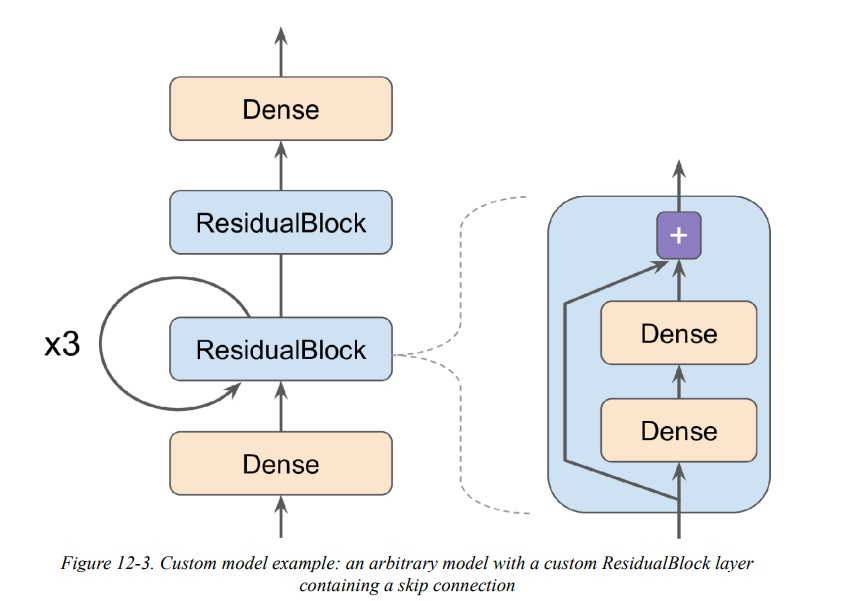

In [27]:
# First let's make a Residual Block as a Custom Layer

class ResidualBlock(keras.layers.Layer):
    def __init__(self, n_layers, units, activation=None, **kwargs):
        self.hidden_layers = [ keras.layers.Dense(units, activation=activation)
         for _ in range(n_layers) ]
        super().__init__(**kwargs)

    def call(self, input):
        x = input
        for layer in self.hidden_layers:
            x = layer[x]
            
        return x + input


In [28]:
# Let's start making our Custom Model using Subclassing API

class MyCustomModel(keras.models.Model):
    def __init__(self, n_iters, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.n_iters = n_iters
        self.dense1 = keras.layers.Dense(30, activation='relu')
        self.residualBlock1 = ResidualBlock(2, 30, activation='relu')
        self.residualBlock2 = ResidualBlock(2, 30, activation='relu')
        self.dense2 = keras.layers.Dense(output_dim)

    def call(self, x):
        x = keras.layers.Flatten(shape=[28, 28])
        x = self.dense1(x)
        for i in range(1 + self.n_iters):
            x = self.residualBlock1(x)
        x = self.residualBlock2(x)
        x = self.dense2(x)

        return x


# **Custom Training Loops**

In [29]:
mnist = keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [30]:
print(x_train.shape, x_test.shape)

(60000, 28, 28) (10000, 28, 28)


In [35]:
x_train = x_train/255.
x_test = x_test/255.

In [36]:
l2_regularizer = keras.regularizers.l2(0.05)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation='elu', kernel_initializer='he_normal',
                       kernel_regularizer=l2_regularizer),
    keras.layers.Dense(100, activation='elu', kernel_initializer='he_normal',
                       kernel_regularizer=l2_regularizer),
    keras.layers.Dense(10, activation='softmax')
])

In [37]:
def random_sample(X, y, batch_size):
    idx = np.random.randint(len(X), size=batch_size)
    return X[idx], y[idx]

In [38]:
def print_status_bar(iterations, total, loss, metrics=None):
    metrics = " - ".join(["{}: {:.4f}".format(m.name(), m.result())
     for m in [loss] + (metrics or [])])
    end = "" if iterations < total else "\n"
    print("\r{}/{}".format(iterations, total) + metrics, end=end)

In [39]:
n_epochs = 5
batch_size = 32
n_steps = len(x_train) // batch_size
optimizer = keras.optimizers.Nadam()
loss_fn = keras.losses.mean_squared_error
mean_loss = keras.metrics.Mean()
metrics = [keras.metrics.MeanAbsoluteError()]

In [34]:
for epoch in range(1, 1 + n_epochs):
    print("Epoch {}/{}".format(epoch, n_epochs))
    for step in range(1, n_steps + 1):
        x_batch, y_batch = random_sample(x_train, y_train)
        with tf.GradientTape as tape:
            y_pred = model(x_batch, training=True)
            main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
            loss = tf.add_n([main_loss] + model.losses)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        mean_loss(loss)
        for metric in metrics:
            metric(y_batch, y_pred)
        print_status_bar(step*batch_size, len(y_train), mean_loss, metrics)
    print_status_bar(len(y_train), len(y_train), loss, metrics)
    for metric in [mean_loss] + metrics:
        metric.reset_status()

